In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [0]:
data_frame = pd.read_csv("Train_TEC_mar17.csv")

In [5]:
data_frame.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


In [0]:
data_frame.drop(["Date", "Month", "Year", "Time"], axis = 1, inplace = True)

In [7]:
data_frame.head()

,LT,TEC
0,5.311333,2.067562
1,5.344670,2.082707
2,5.378006,2.004272
3,5.411343,1.736569
4,5.444679,1.758503


In [0]:
df = pd.DataFrame(data_frame["TEC"])

In [9]:
df.head()

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503


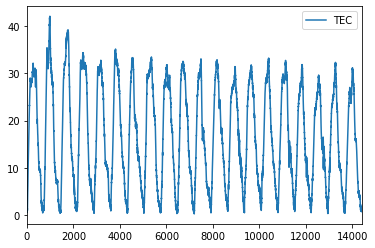

In [10]:
df.plot()

In [11]:
train = df[:-1440]
test = df[-1440:]
train.shape, test.shape

((12960, 1), (1440, 1))

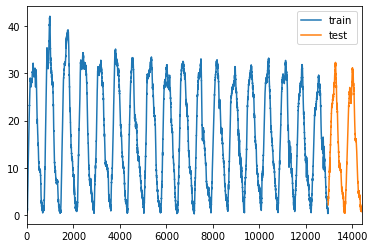

In [12]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [0]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [14]:
train_sc

array([[0.04266831],
       [0.04303103],
       [0.04115251],
       ...,
       [0.02035242],
       [0.01636847],
       [0.02202376]])

In [15]:
test_sc

array([[0.04565388],
       [0.04605349],
       [0.05475397],
       ...,
       [0.02464814],
       [0.02412893],
       [0.03227832]])

In [0]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [0]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [18]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [44]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/100
12959/12959 [==============================] - 27s 2ms/step - loss: 8.4150e-04
Epoch 2/100
   72/12959 [..............................] - ETA: 28s - loss: 0.0010    

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


12959/12959 [==============================] - 27s 2ms/step - loss: 1.2840e-04
Epoch 3/100
12959/12959 [==============================] - 29s 2ms/step - loss: 1.4759e-04
Epoch 4/100
12959/12959 [==============================] - 27s 2ms/step - loss: 1.4392e-04
Epoch 5/100
12959/12959 [==============================] - 27s 2ms/step - loss: 1.4027e-04
Epoch 6/100
12959/12959 [==============================] - 27s 2ms/step - loss: 1.3077e-04
Epoch 7/100
12959/12959 [==============================] - 27s 2ms/step - loss: 1.3487e-04
Epoch 8/100
12959/12959 [==============================] - 28s 2ms/step - loss: 1.2399e-04
Epoch 9/100
12959/12959 [==============================] - 27s 2ms/step - loss: 1.4413e-04
Epoch 10/100
12959/12959 [==============================] - 27s 2ms/step - loss: 1.3472e-04
Epoch 11/100
12959/12959 [==============================] - 28s 2ms/step - loss: 1.3175e-04
Epoch 12/100
12959/12959 [==============================] - 28s 2ms/step - loss: 1.3156e-04
Epoch 13

In [0]:
model_lstm.save('LSTM_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [46]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

1439/1439 [==============================] - 1s 775us/step


In [47]:
print('LSTM: %f'%score_lstm)

LSTM: 0.041635


In [0]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

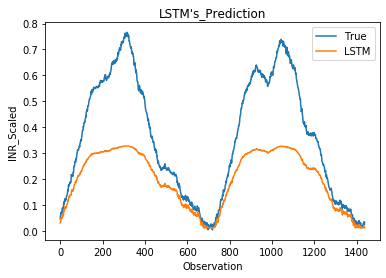

In [49]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('TEC_Scaled')
plt.legend()
plt.show()